In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
torch.set_printoptions(linewidth=120)

In [2]:
def get_num_correct(preds,labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=60)
    self.out = nn.Linear(in_features=60,out_features=10)

  def forward(self,t):
    t=self.conv1(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)

    t=self.conv2(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)

    t=t.reshape(-1,12*4*4)

    t=self.fc1(t)
    t=F.relu(t)

    t=self.fc2(t)
    t=F.relu(t)

    t=self.out(t)

    return t

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [5]:
mynetwork = Network()

In [6]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)
batch = next(iter(train_loader))
images,labels = batch

In [7]:
preds = mynetwork(images)
loss = F.cross_entropy(preds,labels)
loss.item()

2.303933620452881

In [8]:
print(mynetwork.conv1.weight.grad)

None


Now lets apply back propagation

In [9]:
loss.backward()

In [10]:
mynetwork.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

Lets update the weights now

In [11]:
optimizer = optim.Adam(mynetwork.parameters(),lr=0.01)

The network parameters are just the network weights

In [12]:
get_num_correct(preds,labels)

11

This is just a guess prediction where 5 out of 100 was found to be correct

In [13]:
optimizer.step()

In [14]:
preds = mynetwork(images)
loss = F.cross_entropy(preds,labels)
loss.item()

2.272700071334839

The loss has been lowered

In [15]:
get_num_correct(preds,labels)

24

Number of correct prediction also increased

Lets now loop over training process to cover entire batch

In [16]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)

optimizer = optim.Adam(network.parameters(),lr=0.01)


total_loss = 0
total_correct = 0

for batch in train_loader:
  images,labels = batch

  preds = network(images)
  loss = F.cross_entropy(preds,labels)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  total_loss += loss.item()
  total_correct += get_num_correct(preds,labels)

print("epoch:",0,"total_correct:",total_correct,"loss:",total_loss)  

epoch: 0 total_correct: 46881 loss: 343.3387148976326


In [17]:
accuracy = (total_correct/len(train_set))*100
print(accuracy)

78.135


We got an accuracy of 79% for 1st epoch

Now lets train for multiple epochs

In [18]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)

optimizer = optim.Adam(network.parameters(),lr=0.01)

for epoch in range(5):
  total_loss = 0
  total_correct = 0

  for batch in train_loader:
    images,labels = batch

    preds = network(images)
    loss = F.cross_entropy(preds,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct(preds,labels)

  print("epoch:",epoch,"total_correct:",total_correct,"loss:",total_loss)  


epoch: 0 total_correct: 45474 loss: 383.79794281721115
epoch: 1 total_correct: 50740 loss: 254.8563137203455
epoch: 2 total_correct: 51211 loss: 239.12389267981052
epoch: 3 total_correct: 51615 loss: 225.85528580844402
epoch: 4 total_correct: 51833 loss: 217.7157675474882


In [19]:
accuracy = (total_correct/len(train_set))*100
print(f"Accuracy:{accuracy}")

Accuracy:86.38833333333334


We got a really good accuracy over just 5 epochs

Lets create confusion matrix to get a visual acuracy of our model

In [20]:
def get_all_preds(model,loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images,labels = batch
    preds=model(images)
    all_preds = torch.cat(
        (all_preds,preds)
        ,dim=0
    )
  return all_preds 

In [21]:
prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
train_preds = get_all_preds(network,prediction_loader)

In [22]:
train_preds.shape

torch.Size([60000, 10])

This means that for every 60000 points , we have 10 predictions for each class label and the highest value is the class that the model has predicted

In [23]:
print(train_preds.requires_grad)

True


In [24]:
train_preds.grad

<ipython-input-24-54316e76a7d0>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  train_preds.grad


In [25]:
train_preds.grad_fn

In [26]:
with torch.no_grad():
  prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
  train_preds = get_all_preds(network,prediction_loader)

The gradients will not be tracked like this because we are not training , so we wont need the grads

In [27]:
print(train_preds.requires_grad)

False


In [28]:
train_preds.grad

In [29]:
train_preds.grad_fn

In [30]:
preds_correct = get_num_correct(train_preds,train_set.targets)

print("total_correct:",preds_correct)
print('accuracy:',preds_correct/len(train_set))

total_correct: 51826
accuracy: 0.8637666666666667


In [32]:
stacked = torch.stack(
    (
        train_set.targets,
     train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [33]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [34]:
stacked.shape

torch.Size([60000, 2])

In [35]:
cmt = torch.zeros(10,10,dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
for p in stacked:
  j,k=p.tolist()
  cmt[j,k]=cmt[j,k]+1

In [37]:
cmt

tensor([[5570,   12,   72,   68,   10,   14,  184,    0,   66,    4],
        [  47, 5859,    9,   50,    2,    7,   14,    1,   11,    0],
        [ 106,    2, 4817,   42,  539,   14,  398,    0,   81,    1],
        [ 478,  169,    8, 4864,  328,   11,  118,    0,   18,    6],
        [  27,   25,  529,  134, 4611,    8,  574,    0,   92,    0],
        [   3,    0,    0,    0,    0, 5726,    0,  207,    5,   59],
        [1582,   11,  610,   78,  384,    7, 3199,    1,  126,    2],
        [   0,    0,    0,    0,    0,   73,    0, 5877,    0,   50],
        [  23,    8,   19,   21,    7,   72,   24,   17, 5809,    0],
        [   0,    0,    0,    0,    0,   39,    0,  464,    3, 5494]])

The diagonal values are large since thats the position where true and predicted value meet

Easy way is to just import confusion matrix from sklearn

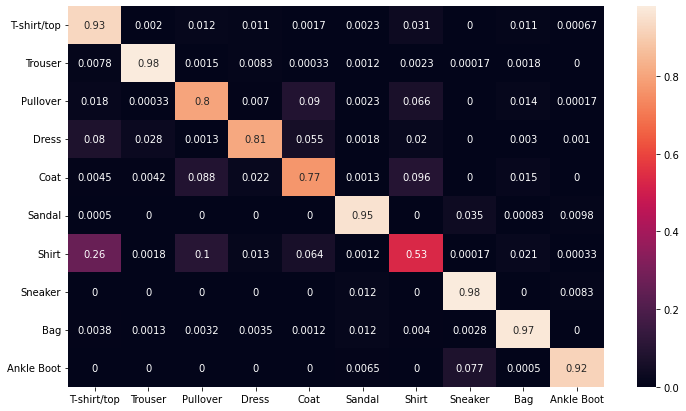

In [43]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in train_loader:
        output = network(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')